This example notebook uses synthetic data produced by PZFlow in combination with several predefined SED templates and filter definition files.

In [1]:
from rail.estimation.algos.lephare import LephareInformer, LephareEstimator
import numpy as np
import lephare as lp
from rail.core.stage import RailStage
import matplotlib.pyplot as plt

DS = RailStage.data_store
DS.__class__.allow_overwrite = True

Default work cache at /Users/rshirley/Library/Caches/lephare/work
                    is already linked. This is linked to the run directory:
                    /Users/rshirley/Library/Caches/lephare/runs/20240506T202124
Number of keywords read in the config file: 86
Number of keywords read in the config file: 86


Here we load previously created synthetic data

In [2]:
import tables_io

trainFile = './data/output_table_conv_train.hdf5'
testFile = './data/output_table_conv_test.hdf5'

traindata_io = tables_io.read(trainFile)
testdata_io = tables_io.read(testFile)

In [9]:
traindata_io

OrderedDict([('mag_err_g_lsst',
              array([0.17053087, 0.02548965, 0.0567911 , 0.01172618, 0.0710584 ,
                     0.0881694 , 0.06282972, 0.0133716 , 0.02475317, 0.03973906,
                     0.07010112, 0.02186605, 0.15332515, 0.02146433, 0.16920464,
                     0.01024634, 0.0247669 , 0.07831078, 0.02618609, 0.19954753,
                     0.11865015, 0.03320735, 0.16592661, 0.00823849, 0.02482817,
                     0.01190062, 0.09179212, 0.0132992 , 0.01077125, 0.01289834,
                     0.01900191, 0.00781632, 0.02535939, 0.06757048, 0.11060295,
                     0.04089504, 0.0065606 , 0.08374166, 0.01618036, 0.08575773,
                     0.00697037, 0.0819266 , 0.16523303, 0.07424783, 0.15033947,
                     0.02509298, 0.0598157 , 0.02797277, 0.11099518, 0.05220913,
                     0.02082684, 0.01652968, 0.04419895, 0.005719  , 0.18951323,
                     0.07656922, 0.0764592 , 0.08466922, 0.09910121, 0.014996

Retrieve all the required filter and template files

In [3]:
lephare_config_file = "../src/rail/estimation/algos/lsst.para"
lephare_config = lp.read_config(lephare_config_file)

lp.data_retrieval.get_auxiliary_data(keymap=lephare_config)

Number of keywords read in the config file: 86
Local registry file is up to date: data_registry.txt
Checking/downloading 404 files...
404 completed.
All files downloaded successfully and are non-empty.


We use the inform stage to create the library of SEDs with various redshifts, extinction parameters, and reddening values. This typically takes ~3-4 minutes.

In [4]:
inform_lephare = LephareInformer.make_stage(
    name="inform_Lephare",
    nondetect_val=np.nan,
    model="lephare.pkl",
    hdf5_groupname="",
)

inform_lephare.inform(traindata_io)

Inserting handle into data store.  input: None, inform_Lephare
Local registry file is up to date: data_registry.txt
Checking/downloading 404 files...
404 completed.
All files downloaded successfully and are non-empty.
# NAME                        IDENT      Lbda_mean Lbeff(Vega)       FWHM     AB-cor    TG-cor      VEGA M_sun(AB)   CALIB      Lb_eff    Fac_corr
total_u.pb                    1             0.3664      0.3720      0.0458    0.7023   -0.2237  -20.9207    6.3126       0      0.3643      1.0000
total_g.pb                    2             0.4842      0.4744      0.1395   -0.0845   -0.2511  -20.7220    5.0903       0      0.4763      1.0000
total_r.pb                    3             0.6251      0.6162      0.1340    0.1519    0.2648  -21.5250    4.6488       0      0.6195      1.0000
total_i.pb                    4             0.7562      0.7497      0.1297    0.3697    0.5838  -22.1618    4.5362       0      0.7520      1.0000
total_z.pb                    5             0.8

Now we take the sythetic test data, and find the best fits from the library. This results in a PDF, zmode, and zmean for each input test data. Takes ~2 minutes to run on 1500 inputs.

In [5]:
estimate_lephare = LephareEstimator.make_stage(
    name="test_Lephare",
    nondetect_val=np.nan,
    model=inform_lephare.get_handle("model"),
    hdf5_groupname="",
    aliases=dict(input="test_data", output="lephare_estim"),
)

lephare_estimated = estimate_lephare.estimate(testdata_io)

####################################### 
# PHOTOMETRIC REDSHIFT with OPTIONS   # 
# Config file            : 
# CAT_IN                 : bidon
# CAT_OUT                : zphot.out
# CAT_LINES              : 0 1000000000
# PARA_OUT               : /Users/rshirley/Library/Caches/lephare/data/examples/output.para
# INP_TYPE               : M
# CAT_FMT[0:MEME 1:MMEE] : 0
# CAT_MAG                : AB
# ZPHOTLIB               : LSST_STAR_MAG LSST_GAL_MAG LSST_QSO_MAG 
# FIR_LIB                : 
# FIR_LMIN               : 7.000000
# FIR_CONT               : -1.000000
# FIR_SCALE              : -1.000000
# FIR_FREESCALE          : YES
# FIR_SUBSTELLAR         : NO
# ERR_SCALE              : 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 
# ERR_FACTOR             : 1.500000 
# GLB_CONTEXT            : 63
# FORB_CONTEXT           : -1
# DZ_WIN                 : 1.000000
# MIN_THRES              : 0.020000
# MAG_ABS                : -24.000000 -5.000000
# MAG_ABS_AGN            : -30.000

An example lephare PDF and comparison to the true value

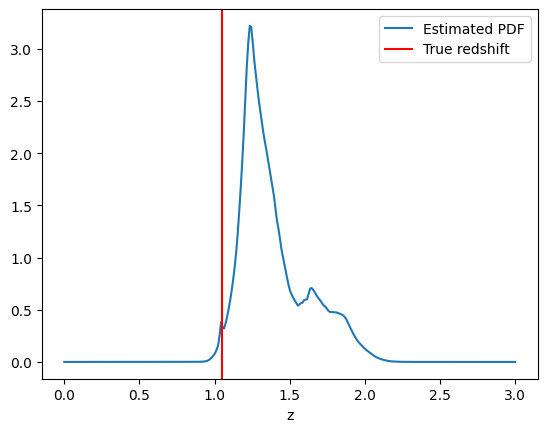

In [6]:
indx = 0
zgrid = np.linspace(0,3,300)
plt.plot(zgrid, np.squeeze(lephare_estimated.data[indx].pdf(zgrid)), label='Estimated PDF')
plt.axvline(x=testdata_io['redshift'][indx], color='r', label='True redshift')
plt.legend()
plt.xlabel('z')
plt.show()

More example fits

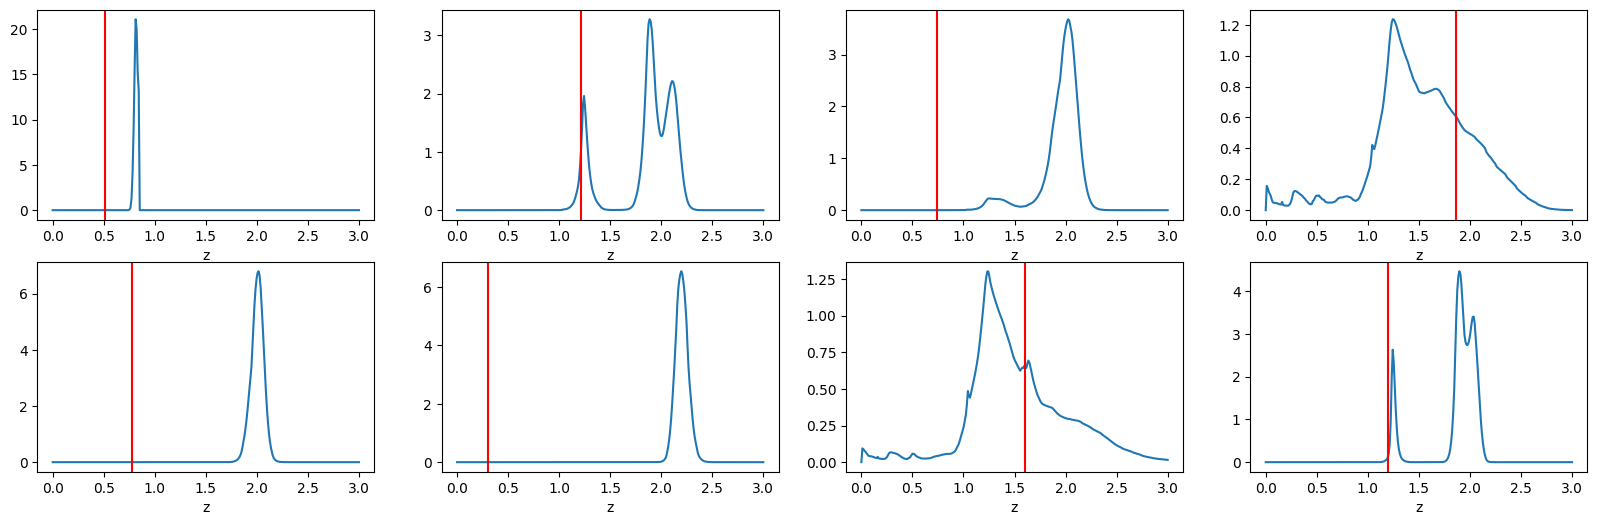

In [7]:
indxs = [8, 16, 32, 64, 128, 256, 512, 1024]
zgrid = np.linspace(0,3,300)
fig, axs = plt.subplots(2,4, figsize=(20,6))
for i, indx in enumerate(indxs):
    ax = axs[i//4, i%4]
    ax.plot(zgrid, np.squeeze(lephare_estimated.data[indx].pdf(zgrid)), label='Estimated PDF')
    ax.axvline(x=testdata_io['redshift'][indx], color='r', label='True redshift')
    ax.set_xlabel('z')

Histogram of the absolute difference between lephare estimate and true redshift

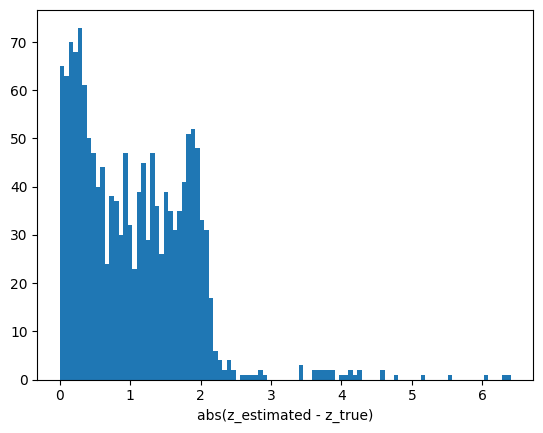

In [8]:
estimate_diff_from_truth = np.abs(lephare_estimated.data.ancil['zmode'] - testdata_io['redshift'])

plt.figure()
plt.hist(estimate_diff_from_truth, 100)
plt.xlabel('abs(z_estimated - z_true)')
plt.show()